# Position based Impedance Control

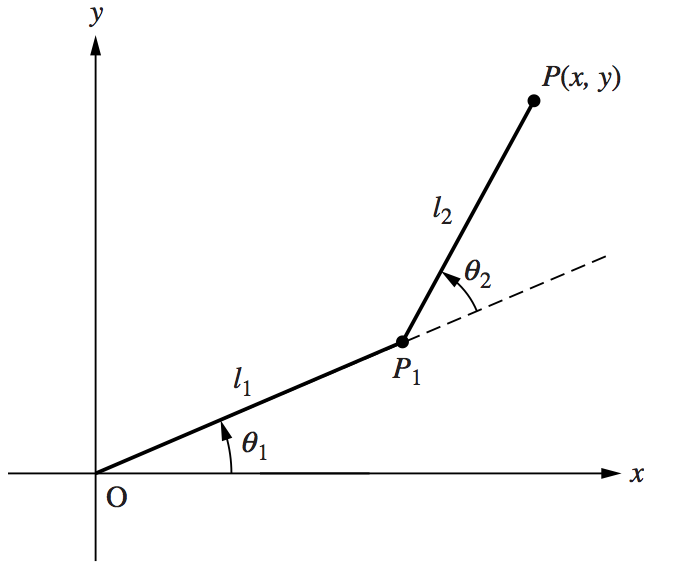

In [239]:
from IPython.display import Image
Image('img/2_link_tutorial_1.png')

In [245]:
import sympy as sp
import numpy as np
from lib import symbolic_modern_robotics as smr


def get_Screw_axis(s,q,h=0):
    w = q.cross(s) + h*s
    w=w.tolist()
    s=s.tolist()
    
    return sum(s+w,[])

### 1. Find Foward Kinematics

In [292]:
import sympy as sp
import numpy as np
from lib import symbolic_modern_robotics as smr

l1,l2,g = sp.symbols('l1,l2,g')
m1,m2 = sp.symbols('m1,m2')
theta_1,theta_2 = sp.symbols('theta_1,theta_2', positive=True)
dtheta_1,dtheta_2 = sp.symbols('thetadot_1,thetadot_2', positive=True)
ddtheta_1,ddtheta_2 = sp.symbols('thetaddot_1,thetaddot_2', positive=True)

thetalist = sp.Matrix([theta_1,theta_2])
dthetalist = sp.Matrix([dtheta_1,dtheta_2])
ddthetalist = sp.Matrix([ddtheta_1,ddtheta_2])



s1 = sp.Matrix([[0,0,1]])    # v = q X s   (Cross Product)
q1 = sp.Matrix([[0,0,0]])    # slist form = [ w , v ]

s2 = sp.Matrix([[0,0,1]])
q2 = sp.Matrix([[l1,0,0]])


Slist = sp.Matrix([get_Screw_axis(s1,q1),
                   get_Screw_axis(s2,q2)]).T

thetalist = sp.Matrix([theta_1,theta_2])

M01 = sp.Matrix([[1,0,0,l1],
                 [0,1,0,0],
                 [0,0,1,0],
                 [0,0,0,1]])

M12 = sp.Matrix([[1,0,0,l2],
                 [0,1,0,0],
                 [0,0,1,0],
                 [0,0,0,1]])

M = M01@M12

Mlist=[M01,M12]

Blist = sp.Matrix([[0, 0, 1, 0, l1+l2, 0],
                  [0, 0, 1, 0, l2, 0]]).T


# Check Forward Kinematics
T01 = smr.MatrixExp6(smr.VecTose3(Slist[:, 0]*thetalist[0]))
T12 = smr.MatrixExp6(smr.VecTose3(Slist[:, 1]*thetalist[1]))
ForKinSpace = T01@T12@M
T01 = smr.MatrixExp6(smr.VecTose3(Blist[:, 0]*thetalist[0]))
T12 = smr.MatrixExp6(smr.VecTose3(Blist[:, 1]*thetalist[1]))
ForKinBody = M@T01@T12

sp.simplify(ForKinSpace-ForKinBody)



Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

### 2. Find Jacobian Matrix

In [328]:
fkin_result_b = smr.FKinBody(M, Blist, thetalist)
Jb = smr.JacobianBody(Blist, thetalist)
R_0_3 = fkin_result_b[0:3,0:3]
J1=R_0_3@Jb[3:,0]
J1.row_del(-1)

J2=R_0_3@Jb[3:,1]
J2.row_del(-1)

J=J1.row_join(J2)

sp.simplify(J)


Matrix([
[-l1*sin(theta_1) - l2*sin(theta_1 + theta_2), -l2*sin(theta_1 + theta_2)],
[ l1*cos(theta_1) + l2*cos(theta_1 + theta_2),  l2*cos(theta_1 + theta_2)]])

### 2. Inverse Dynamics : Find Mass Matrix , Coriolis force , Gravity Vector

In [276]:
g_vec = sp.Matrix([0, -g, 0])
Ftip = sp.Matrix([0,0,0,0,0,0])
G01 = sp.diag(0,0,0, m1, m1, m1)
G12 = sp.diag(0,0,0, m2, m2, m2)
Glist = [G01, G12]

In [277]:
tau, V, Vd = smr.InverseDynamics(thetalist, dthetalist, ddthetalist, g_vec, Ftip, Mlist, Glist, Slist)


In [278]:
Mass,C,G=smr.get_EoM_from_T(tau, ddthetalist, g)

In [279]:
Mass

Matrix([
[l1**2*m1 + l1**2*m2 + 2*l1*l2*m2*cos(theta_2) + l2**2*m2, l2*m2*(l1*cos(theta_2) + l2)],
[                            l2*m2*(l1*cos(theta_2) + l2),                     l2**2*m2]])

In [280]:
C

Matrix([
[-l1*l2*m2*thetadot_2*(2*thetadot_1 + thetadot_2)*sin(theta_2)],
[                          l1*l2*m2*thetadot_1**2*sin(theta_2)]])

In [281]:
G

Matrix([
[g*(l1*m1*cos(theta_1) + l1*m2*cos(theta_1) + l2*m2*cos(theta_1 + theta_2))],
[                                            g*l2*m2*cos(theta_1 + theta_2)]])

### 3. Computed Torque Control

In [269]:
u=M@

Matrix([
[l2*m2*theta_2*(l1*cos(theta_2) + l2) + theta_1*(l1**2*m1 + l1**2*m2 + 2*l1*l2*m2*cos(theta_2) + l2**2*m2)],
[                                                  l2**2*m2*theta_2 + l2*m2*theta_1*(l1*cos(theta_2) + l2)]])